In [ ]:
import keras
from keras.datasets import mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

print('x_train: ' + str(train_x.shape))
print('y_train: ' + str(train_y.shape))
print('x_test:  '  + str(test_x.shape))
print('y_test:  '  + str(test_y.shape))

11490434/11490434 [==============================] - 0s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)



##setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

In [ ]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = tf.expand_dims(x_train, axis = -1), tf.expand_dims(x_test, axis = -1)

In [ ]:
weight_decay = 5e-4
batch_size = 512
num_epochs = 30
dropout_rate = 0.0375
image_size = 56
patch_size = 7
num_patches = (image_size // patch_size) ** 2
embedding_dim = 100
num_blocks = 2

##model wrapper

In [ ]:

def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size, num_patches)(augmented)
    x = layers.Dense(embedding_dim)(patches)
    if positional_encoding:
        x = RoPE()(x)
    x = blocks(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    logits = layers.Dense(num_classes)(x)
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:

def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate, weight_decay=weight_decay, clipvalue=1.
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    print(model.summary())
    # learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = "val_acc", patience=10, restore_best_weights=True
    )

    history = model.fit(
        x = x_train,
        y = y_train,
        batch_size = batch_size,
        epochs = num_epochs,
        validation_split = 0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super().__init__(name = 'patches')
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [ ]:
class RoPE(layers.Layer):
  def __init__(self, dim = 1, *args, **kwargs):
    super(RoPE, self).__init__(*args, **kwargs)
    self.dim = dim

  def call(self, x):
    shape = x.shape
    spatial_shape = [shape[self.dim]]
    total_len = 1
    for i in spatial_shape:
      total_len *= i
    position = tf.reshape(np.arange(total_len, dtype=float), spatial_shape)

    for i in range(self.dim + 1, len(shape) - 1, 1):
      position = tf.expand_dims(position, axis =-1)

    half_size = shape[-1] // 2
    freq_seq = -np.arange(half_size, dtype=float) / float(half_size)
    inv_freq = 10000 ** -freq_seq
    sinusoid = tf.einsum("...,d->...d", position, inv_freq)
    sin = tf.cast(tf.sin(sinusoid), tf.float32)
    cos = tf.cast(tf.cos(sinusoid), tf.float32)

    x1, x2 = tf.split(x, 2, axis = -1)
    return tf.concat([x1 * cos - x2 * sin, x2 * cos + x1 * sin], axis =-1)

##functioning block

In [ ]:
@tf.keras.utils.register_keras_serializable()
class tinyGMLP(layers.Layer):
  def __init__(self, seq_len = num_patches, features = embedding_dim, *args, **kwargs):
    super(tinyGMLP, self).__init__(*args, **kwargs)
    self.norm_in = layers.LayerNormalization()
    self.norm = layers.LayerNormalization()
    self.expand = layers.Dense(2 * features, activation = 'gelu', use_bias = False)
    self.w = self.add_weight(shape = (seq_len), initializer = "zeros", trainable = True)
    self.b = self.add_weight(shape = (seq_len, features), initializer = "ones", trainable = True)
    self.proj = layers.Dense(features)

  def call(self, x):
    u, v = tf.split(self.expand(self.norm_in(x)), 2, -1)
    v = tf.einsum('...sf,s->...sf', self.norm(v), self.w) + self.b
    return self.proj(u * v ) + x

blocks = Sequential([
  Sequential([tinyGMLP() for _ in range(num_blocks)]),
  layers.BatchNormalization(),
  layers.Dense(embedding_dim//4),
  layers.EinsumDense('...sf,sd->...df', (num_patches//4, embedding_dim//4)),
  Sequential([tinyGMLP(num_patches//4, embedding_dim//4) for _ in range(num_blocks)])
])

##training

In [ ]:
"""learning_rate = 0.005
classifier = build_classifier(blocks)
history = run_experiment(classifier)"""

'learning_rate = 0.005\nclassifier = build_classifier(blocks)\nhistory = run_experiment(classifier)'

In [ ]:
#classifier.save("mnist_model.keras")

##applying

In [ ]:
classifier = keras.saving.load_model("mnist_model.keras")

In [ ]:
#create feature vector

#X_train
vector_train1 = classifier(x_train[:3750])
vector_train2 = classifier(x_train[3750:7500])
vector_train3 = classifier(x_train[7500:15000])
vector_train4 = classifier(x_train[15000:30000])
vector_train5 = classifier(x_train[30000:])

vector_train2 = tf.concat([vector_train1, vector_train2], axis = 0)
vector_train3 = tf.concat([vector_train2, vector_train3], axis = 0)
vector_train4 = tf.concat([vector_train3, vector_train4], axis = 0)
vector_train5 = tf.concat([vector_train4, vector_train5], axis = 0)

#y_train
y_train1 = y_train[:3750]
y_train2 = y_train[:7500]
y_train3 = y_train[:15000]
y_train4 = y_train[:30000]
y_train5 = y_train

#X_test
vector_test1 = classifier(x_test[:625])
vector_test2 = classifier(x_test[625:1250])
vector_test3 = classifier(x_test[1250:2500])
vector_test4 = classifier(x_test[2500:5000])
vector_test5 = classifier(x_test[5000:])

vector_test2 = tf.concat([vector_test1, vector_test2], axis = 0)
vector_test3 = tf.concat([vector_test2, vector_test3], axis = 0)
vector_test4 = tf.concat([vector_test3, vector_test4], axis = 0)
vector_test5 = tf.concat([vector_test4, vector_test5], axis = 0)

#y_test
y_test1 = y_test[:625]
y_test2 = y_test[:1250]
y_test3 = y_test[:2500]
y_test4 = y_test[:5000]
y_test5 = y_test


vector_test = classifier(x_test)
#example for dealing with testing data
##lookup_vector_to_pixel = dict([(vector_test[_], x_test[_]) for _ in range(len(x_test))])
##lookup_pixel_to_class = dict([(x_test[_], y_test[_]) for _ in range(len(x_test))])

#now we can construct a graph with the features extracted
#and look up for the class to check if it's correct

In [ ]:
vector_train1.shape

TensorShape([3750, 10])

###Access the accuracy of the extraction

In [ ]:

#softmax to convert the number into [0,1]
v = layers.Activation('softmax')(vector_test)

#find the largest features, which indicates which class it belongs to
v = [np.argmax(v[_]) for _ in range(len(v))]
v = np.array(v)

#if same class, then have 1
acc = [v[_]==y_test[_] for _ in range(len(v))]
np.sum(np.array(acc))/len(acc)

0.9864

# HNSW

In [ ]:
Build_size = [3750, 6250, 15000, 30000, 60000]
Query_size = [625, 1250, 2500, 5000, 10000]
Build_time = []
Query_time = []
Accuracy = []

In [ ]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.7.0-cp310-cp310-linux_x86_64.whl size=2203254 sha256=5a4082b659a3634ad2bf7a068a57eb43f22ef88ec6ec011ae29e8a6108866c72
  Stored in directory: /root/.cache/pip/wheels/8a/ae/ec/235a682e0041fbaeee389843670581ec6c66872db856dfa9a4
Successfully built hnswlib


In [ ]:
import hnswlib
import numpy as np

In [ ]:
import timeit

In [ ]:
labels=[]

## Train, test 1 (3750, 625)

In [ ]:
%%timeit -o
p = hnswlib.Index(space = 'l2', dim = 10)
p.init_index(max_elements = 60000, M = 16, ef_construction = 500, random_seed = 100, allow_replace_deleted = False)
p.set_ef(50)
p.set_num_threads(4)
p.add_items(vector_train1, y_train1)

29.7 ms ± 6.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 29.7 ms ± 6.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [ ]:
Build_time.append(_.average)

In [ ]:
%%timeit -o
labels, distances = p.knn_query(vector_test1, k = 1)

614 µs ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 614 µs ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [ ]:
Query_time.append(_.average)

In [ ]:
v = labels
acc = [v[_]==y_test1[_] for _ in range(len(v))]
acc = np.sum(np.array(acc))/len(acc)
print(f"accuracy: {acc}")

accuracy: 0.9024


In [ ]:
Accuracy.append(acc)

## Train, test 2 (7500, 1250)

In [ ]:
%%timeit -o
p = hnswlib.Index(space = 'l2', dim = 10)
p.init_index(max_elements = 60000, M = 16, ef_construction = 500, random_seed = 100, allow_replace_deleted = False)
p.set_ef(50)
p.set_num_threads(4)
p.add_items(vector_train2, y_train2)

49.6 ms ± 904 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 49.6 ms ± 904 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [ ]:
Build_time.append(_.average)

In [ ]:
%%timeit -o
labels, distances = p.knn_query(vector_test2, k = 1)

992 µs ± 6.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 992 µs ± 6.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [ ]:
Query_time.append(_.average)

In [ ]:
v = labels
acc = [v[_]==y_test2[_] for _ in range(len(v))]
acc = np.sum(np.array(acc))/len(acc)
print(f"accuracy: {acc}")

accuracy: 0.9288


In [ ]:
Accuracy.append(acc)

## Train, test 3 (15000, 2500)

In [ ]:
%%timeit -o
p = hnswlib.Index(space = 'l2', dim = 10)
p.init_index(max_elements = 60000, M = 16, ef_construction = 500, random_seed = 100, allow_replace_deleted = False)
p.set_ef(50)
p.set_num_threads(4)
p.add_items(vector_train3, y_train3)

109 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 109 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [ ]:
Build_time.append(_.average)

In [ ]:
%%timeit -o
labels, distances = p.knn_query(vector_test3, k = 1)

2.11 ms ± 306 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 2.11 ms ± 306 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [ ]:
Query_time.append(_.average)

In [ ]:
v = labels
acc = [v[_]==y_test3[_] for _ in range(len(v))]
acc = np.sum(np.array(acc))/len(acc)
print(f"accuracy: {acc}")

accuracy: 0.9464


In [ ]:
Accuracy.append(acc)

## Train, test 4 (30000, 5000)

In [ ]:
%%timeit -o
p = hnswlib.Index(space = 'l2', dim = 10)
p.init_index(max_elements = 60000, M = 16, ef_construction = 500, random_seed = 100, allow_replace_deleted = False)
p.set_ef(50)
p.set_num_threads(4)
p.add_items(vector_train4, y_train4)

250 ms ± 72.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 250 ms ± 72.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [ ]:
Build_time.append(_.average)

In [ ]:
%%timeit -o
labels, distances = p.knn_query(vector_test4, k = 1)

4.95 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 4.95 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [ ]:
distances.shape

(5000, 1)

In [ ]:
labels.shape

(5000, 1)

In [ ]:
Query_time.append(_.average)

In [ ]:
v = labels
acc = [v[_]==y_test4[_] for _ in range(len(v))]
acc = np.sum(np.array(acc))/len(acc)
print(f"accuracy: {acc}")

accuracy: 0.874


In [ ]:
Accuracy.append(acc)

## Train, test 5 (60000, 10000)

In [ ]:
%%timeit -o
p = hnswlib.Index(space = 'l2', dim = 10)
p.init_index(max_elements = 60000, M = 16, ef_construction = 500, random_seed = 100, allow_replace_deleted = False)
p.set_ef(50)
p.set_num_threads(4)
p.add_items(vector_train5, y_train)

547 ms ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 547 ms ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [ ]:
Build_time.append(_.average)

In [ ]:
%%timeit -o
labels, distances = p.knn_query(vector_test5, k = 1)


7.14 ms ± 72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 7.14 ms ± 72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [ ]:
Query_time.append(_.average)

In [ ]:
v = labels
acc = [v[_]==y_test[_] for _ in range(len(v))]
acc = np.sum(np.array(acc))/len(acc)
print(f"accuracy: {acc}")

accuracy: 0.9593


In [ ]:
Accuracy.append(acc)

## HNSW Performance Evaluation

In [ ]:
Query_size

[625, 1250, 2500, 5000, 10000]

In [ ]:
Build_time

[0.0297226569714277,
 0.04961749099999711,
 0.10879741684285753,
 0.2503989297142977,
 0.5468805730000342]

In [ ]:
Query_time

[0.0006144502388571595,
 0.0009920559821428826,
 0.0021052383218571357,
 0.004948738152857004,
 0.007143129118571291]

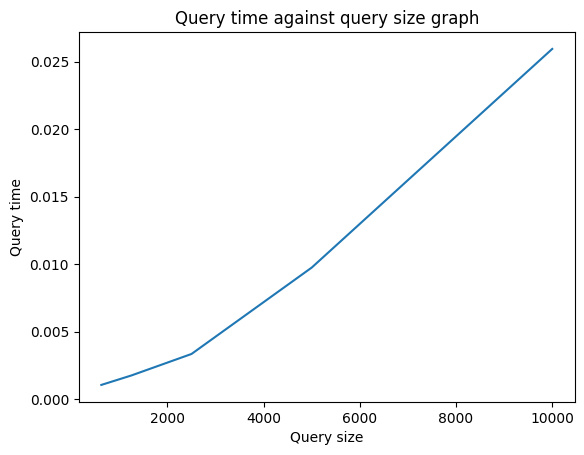

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Query_size, Query_time)
plt.xlabel("Query size")
plt.ylabel("Query time")
plt.title("Query time against query size graph")
plt.show()

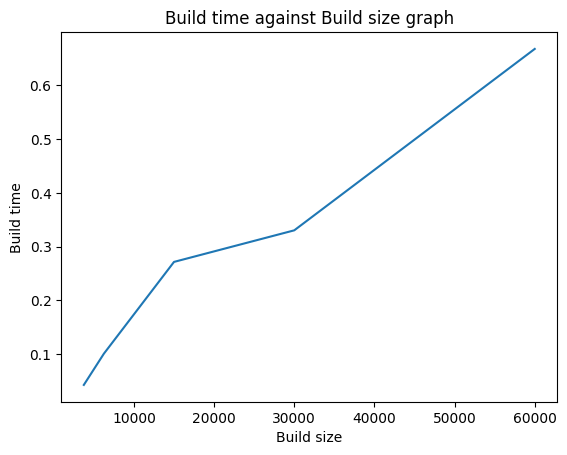

In [ ]:
plt.plot(Build_size, Build_time)
plt.xlabel("Build size")
plt.ylabel("Build time")
plt.title("Build time against Build size graph")
plt.show()

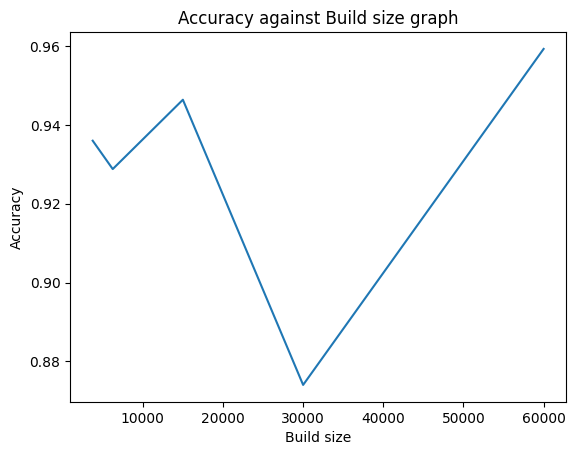

In [ ]:
plt.plot(Build_size, Accuracy)
plt.xlabel("Build size")
plt.ylabel("Accuracy")
plt.title("Accuracy against Build size graph")
plt.show()

# NSW

In [ ]:
Build_size = [3750, 6250, 15000, 30000, 60000]
Query_size = [625, 1250, 2500, 5000, 10000]
Build_time = []
Query_time = []
Accuracy = []

In [ ]:
import nsw

ModuleNotFoundError: ignored